In [12]:
import numpy as np
import pandas as pd
from scipy import stats


In [13]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [14]:
dataset=pd.read_csv('wine.data')
dataset=np.array(dataset)
np.random.shuffle(dataset)
train_dataset,test_dataset=dataset[:round(0.7*len(dataset))],dataset[round(0.7*len(dataset)):len(dataset)]

使用正态分布计算连续值的先验概率，这一过程因此不需要考虑平滑化问题。

In [15]:
mean=[]
variable=[]
train_dataset=sorted(train_dataset,key=lambda x:x[0])
index1,index2=0,0
for i in range(len(train_dataset)):
    if(train_dataset[i][0])==1:
        index1=i+1
    elif(train_dataset[i][0])==2:
        index2=i+1

#print(train_dataset[index1])
count_ratio=[index1/len(train_dataset),index2/len(train_dataset),1-index1/len(train_dataset)-index2/len(train_dataset)]
index_map=[0,index1,index2,len(train_dataset)]
train_dataset=pd.DataFrame(train_dataset)
#print(train_dataset)

In [16]:
record_mean=np.zeros([3,13])
record_var=np.zeros([3,13])

In [17]:
statisc=[0,0,0]
for index in range(0,3):
    for i in range(0,13):
        mean_x=np.mean(train_dataset[i][index_map[index]:index_map[index+1]])
        variable=np.var(train_dataset[i][index_map[index]:index_map[index+1]],ddof=1)
        record_mean[index][i-1]=mean_x
        record_var[index][i-1]=variable
#print(record_mean)
print(record_var)
    

[[2.19118151e-01 5.79179328e-01 4.88282353e-02 4.75843697e+00
  1.19011765e+02 8.81205042e-02 1.73937479e-01 5.99462185e-03
  1.79152605e-01 1.43093580e+00 1.37070588e-02 1.09807899e-01
  0.00000000e+00]
 [3.39192453e-01 1.02751925e+00 1.01440112e-01 1.14575856e+01
  3.15763802e+02 2.82168728e-01 5.86655940e-01 1.35503843e-02
  4.15237736e-01 9.41576799e-01 4.61012607e-02 2.83743990e-01
  0.00000000e+00]
 [2.78548235e-01 1.21424790e+00 3.40667227e-02 5.63949580e+00
  1.24652101e+02 1.04394622e-01 8.39882353e-02 1.67146218e-02
  1.39388739e-01 4.85168271e+00 1.41146218e-02 6.57028571e-02
  0.00000000e+00]]


In [18]:
def normal_arrtribution(x,mean,var):
    #print(stats.norm.pdf(x, mean, var))
    return stats.norm.pdf(x, mean, var)

In [19]:
def calculate_likelyhood(data,group):
    possible=[]
    for i in range(1,13):
        possible.append(normal_arrtribution(data[i],record_mean[group][i-1],record_var[group][i-1]))
    likelyhood=1
    for iternum in range(0,len(possible)):
        likelyhood= likelyhood*possible[iternum]
    return likelyhood

In [20]:
confusion_matrix=np.zeros([3,3])
def test_set_cul():
    for index in range(0,len(test_dataset)):
        caled=[]
        for iterable in range(0,3):
            caled_num=calculate_likelyhood(test_dataset[index],iterable)*count_ratio[iterable]
            caled.append(caled_num)
        res=np.argmax(caled) #Hypotheized
        #print('  ')
        true_class=round(test_dataset[index][0])-1 
        confusion_matrix[res][true_class]=confusion_matrix[res][true_class]+1
    #print(confusion_matrix)
test_set_cul()

In [21]:
import torch
def test_set_cul_ROC():
    mat_belief=[]
    predicted=[]
    for index in range(0,len(test_dataset)):
        caled=[]
        for iterable in range(0,3):
            caled_num=calculate_likelyhood(test_dataset[index],iterable)
            caled.append(caled_num)
        sum_class=sum(caled)
        for class_iter in range(0,3):
            caled[class_iter]=caled[class_iter]/sum_class
            score=max(caled)
            if round(test_dataset[index][0])-1 ==np.argmax(caled):
                right=1
            else:
                right=0
            #print(caled[class_iter])
        mat_belief.append([score,right])

    return mat_belief
res=test_set_cul_ROC()
print(res)

[[1.0, 0], [0.9372433320645259, 1], [0.9932653043109044, 0], [1.0, 0], [1.0, 1], [1.0, 0], [0.999988020439612, 1], [1.0, 1], [1.0, 1], [1.0, 1], [1.0, 0], [1.0, 1], [1.0, 1], [0.9999999999999954, 0], [1.0, 1], [1.0, 1], [1.0, 1], [1.0, 1], [0.998730623985682, 1], [1.0, 1], [0.9999993162362752, 1], [1.0, 0], [0.9999967163798701, 1], [1.0, 1], [0.9999999999999917, 1], [1.0, 1], [1.0, 1], [1.0, 1], [1.0, 1], [0.9999996647259569, 1], [0.9999839135750465, 0], [1.0, 1], [1.0, 0], [0.9163718664598666, 0], [1.0, 1], [0.9999999999999993, 1], [0.9999971700655543, 0], [1.0, 0], [1.0, 1], [0.9171599969498342, 0], [0.7541210836324308, 1], [0.9999999930533395, 0], [0.9999999999988665, 1], [0.8036530514461113, 1], [0.9999998531685812, 1], [1.0, 0], [0.9535747885267271, 1], [1.0, 1], [1.0, 0], [1.0, 1], [1.0, 1], [1.0, 0], [1.0, 1]]


In [22]:
ROC_belief_therehold=np.arange(0,1,0.05)

In [23]:
def precision(type):
    return confusion_matrix[type][type]/sum(confusion_matrix[type,:])
def recall(type):
    return confusion_matrix[type][type]/sum(confusion_matrix[:,type])
def F_ratio(type):
    prec=precision(type)
    print('The precison of type {:n} is {:%}'.format(type, prec))
    reca=recall(type)
    print('The recall of type {:n} is {:%}'.format(type, reca))
    F=2/((1/prec)+(1/reca))
    print('The F-measure of type {:n} is {:%}'.format(type, F))
    print('\n')
for i in np.arange(3):
    F_ratio(i)


The precison of type 0 is 100.000000%
The recall of type 0 is 34.782609%
The F-measure of type 0 is 51.612903%


The precison of type 1 is 37.777778%
The recall of type 1 is 100.000000%
The F-measure of type 1 is 54.838710%


The precison of type 2 is nan%
The recall of type 2 is 0.000000%
The F-measure of type 2 is nan%




C:\Users\32068\AppData\Local\Temp/ipykernel_21416/807471060.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return confusion_matrix[type][type]/sum(confusion_matrix[type,:])
C:\Users\32068\AppData\Local\Temp/ipykernel_21416/807471060.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  F=2/((1/prec)+(1/reca))


多少正样本被预测出来/多少负样本

In [24]:
res=sorted(res)
scores,labels=np.zeros(len(res)),np.zeros(len(res))
for item in range(len(res)):
    scores[item]=res[item][0]
    labels[item]=res[item][1]
print(scores)
print(labels)


[0.75412108 0.80365305 0.91637187 0.91716    0.93724333 0.95357479
 0.9932653  0.99873062 0.99998391 0.99998802 0.99999672 0.99999717
 0.99999932 0.99999966 0.99999985 0.99999999 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]
[1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1.]


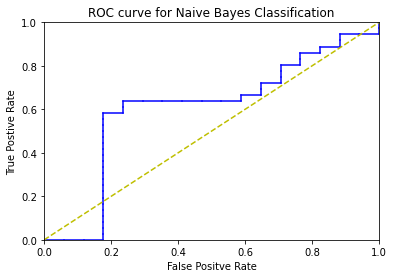

the Area under the curve is: 0.6029411764705884


In [25]:
def plotROC(predStrengths, classLabels):
    cur=(0.0, 0.0)
    numPosClass = np.sum(np.array(classLabels) == 1.0)
    yStep = 1.0/numPosClass
    xStep = 1.0/(len(classLabels)-numPosClass)
    sortedIndicies = np.argsort(-np.array(predStrengths.flatten()))
    fig = plt.figure()
    fig.clf()
    ySum = 0.0
    ax = plt.subplot(111)
    for index in sortedIndicies:
        if classLabels[index] == 1.0:
            delY = yStep; delX=0
        else:
            delY = 0; delX = xStep
            ySum += cur[1]
        ax.plot([cur[0], cur[0]+delX], [cur[1], cur[1]+delY], c='b')
        cur = (cur[0]+delX, cur[1]+delY)
    ax.plot([0, 1], [0, 1], 'y--')
    ax.axis([0, 1, 0, 1])
    plt.xlabel('False Positve Rate')
    plt.ylabel('True Postive Rate')
    plt.title('ROC curve for Naive Bayes Classification')
    ax.axis([0, 1, 0, 1])
    plt.show()
    print('the Area under the curve is:', ySum*xStep)
import matplotlib.pyplot as plt
plotROC(scores,labels)